# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/)

# Vanilla Autoencoder

Все импорты и некоторые вспомогательные ф-ии лежат в модуле utils.py для лучшей читаемости тетрадки.

In [1]:
from utils import *
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Сохраним измененные изображение, чтобы при перезапуске тетрадки каждый раз заново их не изменять.

In [2]:
%%time
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)
with open('attrs.pkl', 'wb') as f:
    pickle.dump(attrs, f)

Wall time: 31.1 s


In [3]:
# загрузим ранее сохраненные данные
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)
with open('attrs.pkl', 'rb') as f:
    attrs = pickle.load(f)

In [4]:
data.shape

(13143, 48, 48, 3)

In [5]:
attrs.head()

Male     Asian     White     Black     Baby     Child      Youth  \
0   1.56835  -1.88904    1.7372 -0.929729  -1.4718  -0.19558  -0.835609   
1  0.169851 -0.982408  0.422709  -1.28218 -1.36006 -0.867002  -0.452293   
2  0.997749  -1.36419 -0.157377 -0.756447 -1.89183 -0.871526  -0.862893   
3   1.12272   -1.9978   1.91614  -2.51421 -2.58007  -1.40424  0.0575511   
4   1.07821   -2.0081   1.67621  -2.27806 -2.65185  -1.34841   0.649089   

   Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
0    -0.351468  -1.01253  -0.719593  ...  0.361738           1.16612   
1    -0.197521 -0.956073  -0.802107  ... -0.832036          -0.39768   
2    0.0314447  -1.34152 -0.0900375  ...   1.54974           1.88475   
3  0.000195882  -1.27351   -1.43146  ...  0.567822         -0.176089   
4    0.0176564  -1.88911   -1.85721  ...  -1.46147         -0.955283   

  Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0                -1.16492         -1.13999     -2.37175        -1.29993   
1                 0.87416        -0.945431    -0.268649     -0.00624408   
2               -0.999765         -1.35986     -1.91211        -1.09563   
3                 1.10812         -1.60094     -3.26461        0.813418   
4                0.119113         -1.12818     -3.16105       0.0826804   

  Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
0  -0.414682          -1.1449        0.694007        -0.826609  
1 -0.0304057        -0.480128         0.66676        -0.496559  
2   0.915126        -0.572332        0.144262        -0.841231  
3   0.308631        -0.848693        0.475941        -0.447025  
4  -0.439614        -0.359859       -0.760774        -0.410152  

[5 rows x 73 columns]

In [6]:
# зафиксируем random_state для повторяемости, разобьем data и attrs на train и val 80 на 20
data_train, data_val, attrs_train, attrs_val = train_test_split(
    data, attrs, test_size=0.2, shuffle=True, random_state=42)

In [7]:
print(data_train.shape)
print(data_val.shape)
print(attrs_train.shape)
print(attrs_val.shape)

(10514, 48, 48, 3)
(2629, 48, 48, 3)
(10514, 73)
(2629, 73)


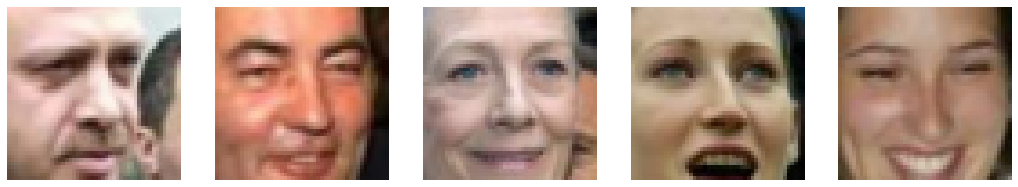

In [8]:
# выведем несколько изображений
plt.figure(figsize=(18, 6))
for i in range(5):
    image = data_train[i]
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image)

In [9]:
# сделаем pytorch dataloaders
batch_size = 256
train_loader = data_utils.DataLoader(np.moveaxis(data_train, 3, 1), batch_size=batch_size)
val_loader = data_utils.DataLoader(np.moveaxis(data_val, 3, 1), batch_size=batch_size)

## Autoencoder
В этом разделе мы напишем и обучим обычный автоэнкодер.

<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [10]:
dim_code = (256, 1, 1) # размер латентного вектора, т.е. code, самой "узкой" части автоэнкодера

Реализуем сверточный autoencoder.

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.encoder = nn.Sequential(nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ))
        
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),            
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)

        return reconstruction, latent_code

Ф-ии для отрисовки изображений и графиков можно найти в utils.py.
Ф-ю train я тоже решил перенести туда для читаемости тетрадки, т.к. я решил написать универсальный train для всех моделей и датасетов, которые использовались в задании. В итоге она стала довольно громоздкой и сложной.

In [12]:
print(train.__doc__)


    :param model: модель
    :param opt: оптимизатор
    :param loss_fn: ф-я потерь
    :param epochs: количество эпох
    :param data_tr: данные для обучения
    :param data_val: данные для проверки
    :param sheduler: шедулер
    :param pictures: нужен ли вывод изображений
    :param cmap: цветовая карта вывода изображений
    :param im_num: кол-во изображений для вывода
    :param model_type: 'AE', 'VAE', 'CVAE' - тип модели
    :param data: 'faces' or 'mnist' - используемый датасет
    :param noise_factor: [0 : 1] - фактор шума
    :return: словарь с данными о обучении
    


In [13]:
autoencoder = Autoencoder().to(device)

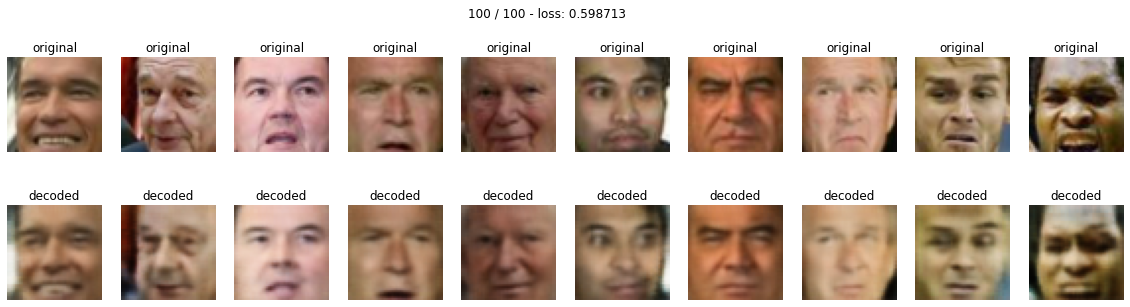

Wall time: 2min 58s


In [14]:
%%time
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
max_epochs = 100
history = train(autoencoder, optimizer, criterion, max_epochs, 
                train_loader, val_loader, pictures=True)

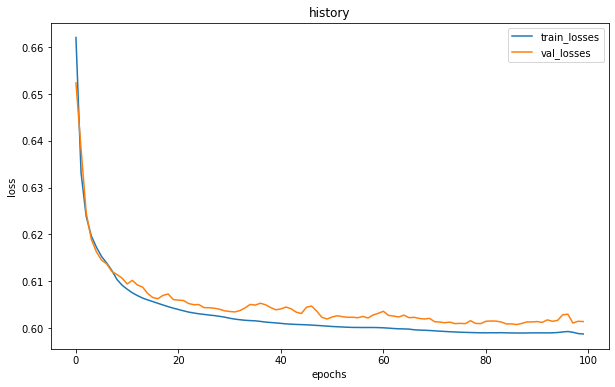

In [15]:
history_plot(history)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

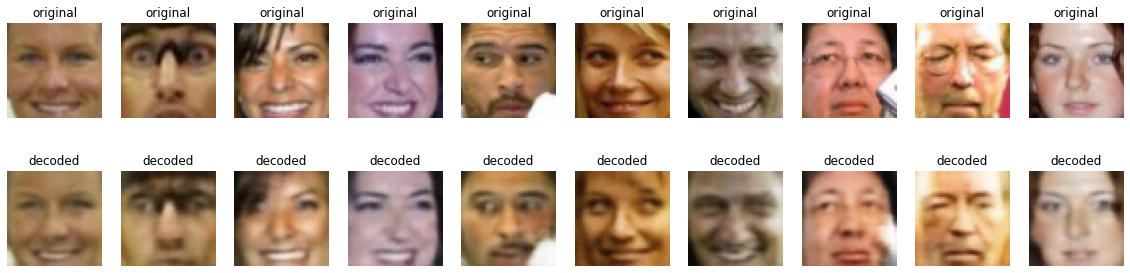

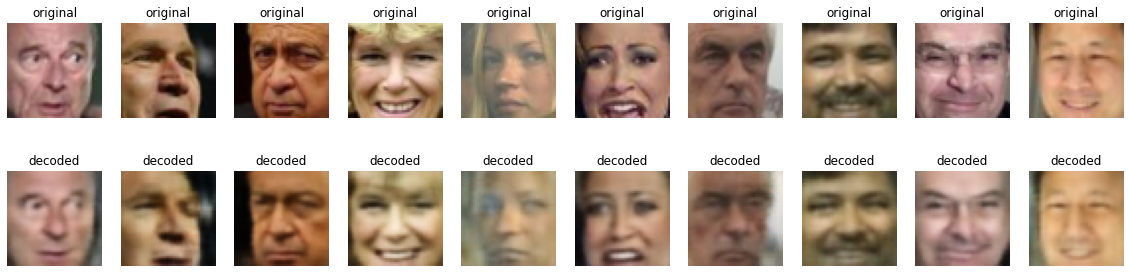

In [16]:
autoencoder.eval()
X_val = next(iter(val_loader))[:10]
X_enc = autoencoder(X_val.float().to(device))[0].detach().cpu()
image_show(X_val, X_enc)
X_val = next(iter(val_loader))[10:20]
X_enc = autoencoder(X_val.float().to(device))[0].detach().cpu()
image_show(X_val, X_enc)

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

train ф-я возвращает latent_code для train и valid данных. Возьмем распределение из train.

In [17]:
latent_codes = history['train_codes'].detach().cpu().numpy()
latent_codes.shape

(10514, 256, 1, 1)

Посчитаем mean и std

In [18]:
print('mean =', f'{latent_codes.flatten().mean():.2f}')
print('std =', f'{latent_codes.flatten().std():.2f}')

mean = 0.69
std = 0.68


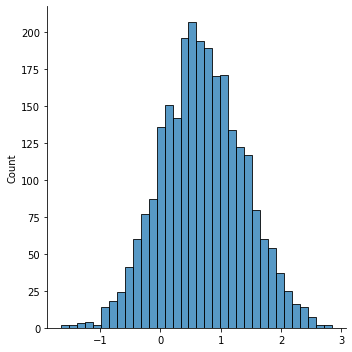

In [19]:
# сгенерируем 10 рандомных векторов размера latent_space
z = torch.normal(0.70, 0.68, size=(10,)+dim_code)
# глянем распределение
sns.displot(z.flatten());

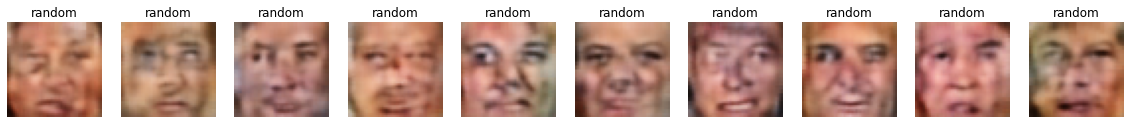

In [20]:
#<выведите тут полученные картинки>
autoencoder.eval()
output = autoencoder.decode(z.to(device))
output = output.detach().cpu()
image_show(output[:10], t1='random')

Looks like me in better days!

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

Возьмем по 20 изображений с макс и мин значение "улыбки" (сохраним гендерный баланс, возьмем по 10 мужчин и 10 женщин, чтобы помимо добавления улыбок, сеть не начала еще и менять пол, тк большинство макс улыбок у женщин, а самые грустненькие - мужчины:( ) 

In [21]:
smile_idx_m = attrs[attrs.Male > 0].Smiling.sort_values().index[-10:]
smile_idx_f = attrs[attrs.Male < 0].Smiling.sort_values().index[-10:]
smile_idx = smile_idx_f.append(smile_idx_m)
sad_idx_m = attrs[attrs.Male > 0].Smiling.sort_values().index[:10]
sad_idx_f = attrs[attrs.Male < 0].Smiling.sort_values().index[:10]
sad_idx = sad_idx_m.append(sad_idx_f)
smiling_faces = data[smile_idx]
sad_faces = data[sad_idx]

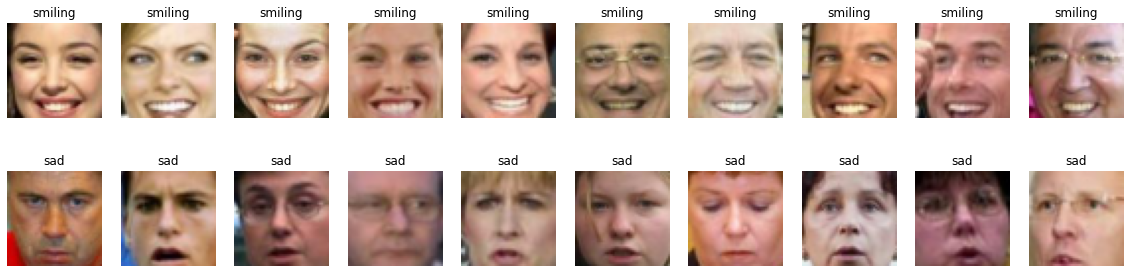

In [22]:
# выведем по 10 грустных и 10 улыбающихся фотографии
plt.figure(figsize=(20, 5))
for i in range(5, 15):
    image = smiling_faces[i]
    plt.subplot(2, 10, i-4)
    plt.axis('off')
    plt.title('smiling')
    plt.imshow(image)
    
    image = sad_faces[i]
    plt.subplot(2, 10, i+6)
    plt.axis('off')
    plt.title('sad')
    plt.imshow(image)    

Прогоним фотки через encoder и сохраним латентные вектора

In [23]:
smiling_codes = autoencoder.encode(
    torch.FloatTensor(np.moveaxis(smiling_faces, 3, 1)).to(device))
sad_codes = autoencoder.encode(
    torch.FloatTensor(np.moveaxis(sad_faces, 3, 1)).to(device))

In [24]:
# средний вектор улыбающихся людей
smiling_code = smiling_codes.mean(dim=0)
# средний вектор грустных людей
sad_code = sad_codes.mean(dim=0)
# вектор улыбки
smile = smiling_code - sad_code
# добавим улыбки грустным людям
smiled_codes = sad_codes + smile

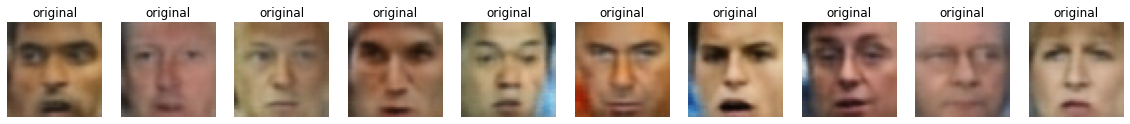

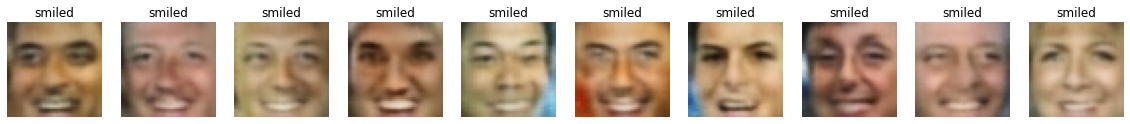

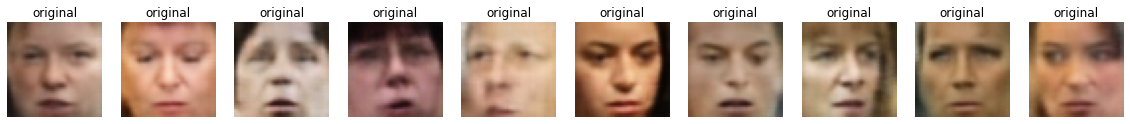

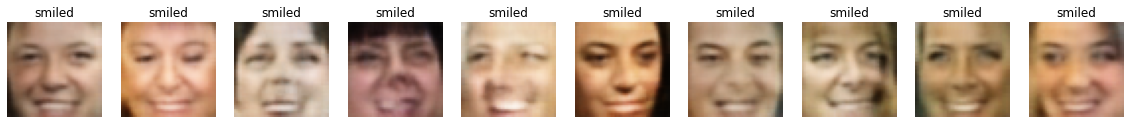

In [25]:
# прогоним получившиеся вектора через decoder и выведем изображения
autoencoder.eval()
original = autoencoder.decode(sad_codes.to(device)).detach().cpu()
smiled = autoencoder.decode(smiled_codes.to(device)).detach().cpu()

image_show(original[:10], t1='original')
image_show(smiled[:10], t1='smiled')
image_show(original[10:20], t1='original')
image_show(smiled[10:20], t1='smiled')

# Variational Autoencoder.

Возьмем ту же структуру свертночных слоёв, что была в ванильном АЕ, только выкинем один слой, т.к. размеры изображений 28 * 28, а не 48 * 48. Ну и добавим полносвязные слои, которые будут считать mu и logsigma и семплирование вектора по их распределению.

In [26]:
class VAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=128):
        super().__init__()
        
        self.fc_mu = nn.Linear(latent_dim, latent_dim)
        self.fc_logsigma = nn.Linear(latent_dim, latent_dim)
        
        self.latent_dim = latent_dim
        
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, latent_dim, kernel_size=4, stride=2),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU()
        )
        
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, kernel_size=5, stride=2),
            nn.BatchNorm2d(64),            
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)

        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(logsigma / 2)
            q = torch.distributions.Normal(mu, std)
            z = q.rsample()
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, x):     
        x = x.view(x.size(0), self.latent_dim, 1, 1)      
        reconstruction = self.decoder(x)
        
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return reconstruction, (mu, logsigma)

Определим лосс и его компоненты для VAE:

лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [27]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = 0.5 * torch.sum(1 + logsigma - mu ** 2 - logsigma.exp())
    
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')

    return loss(reconstruction, x)

def loss_vae(reconstruction, x, mu, logsigma):

    return log_likelihood(x, reconstruction) - KL_divergence(mu, logsigma)

И обучим модель:

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

train_mnist = datasets.MNIST('./', train=True, download=True, transform=transform)
test_mnist = datasets.MNIST('./', train=False, download=True, transform=transform)

train_loader_mnist = data_utils.DataLoader(
    train_mnist, batch_size=256, shuffle=True)
test_loader_mnist = data_utils.DataLoader(
    test_mnist, batch_size=256, shuffle=False)

In [29]:
v_autoencoder = VAE().to(device)

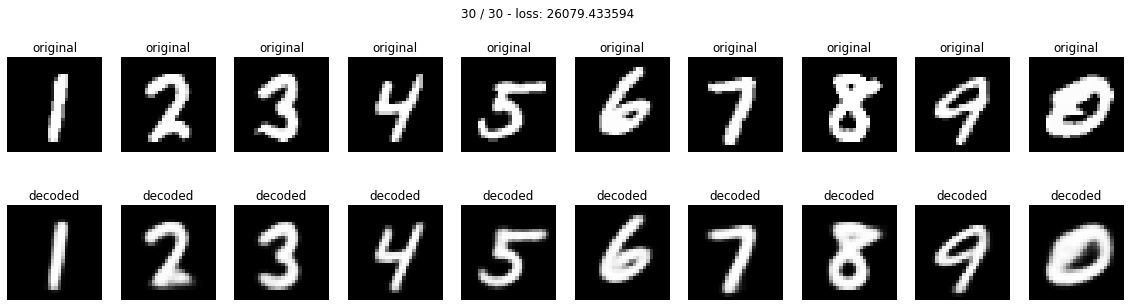

Wall time: 2min 55s


In [30]:
%%time
max_epochs = 30
criterion = loss_vae
optimizer = torch.optim.Adam(v_autoencoder.parameters(), lr=0.001)
history = train(v_autoencoder, optimizer, criterion, max_epochs, 
                train_loader_mnist, test_loader_mnist, pictures=True, 
                model_type='VAE', data='mnist', cmap='gray')

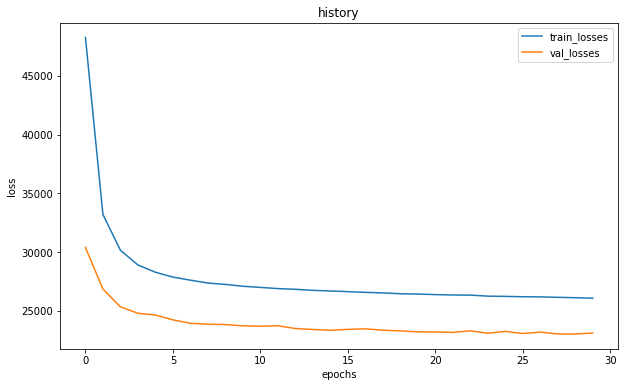

In [31]:
history_plot(history)

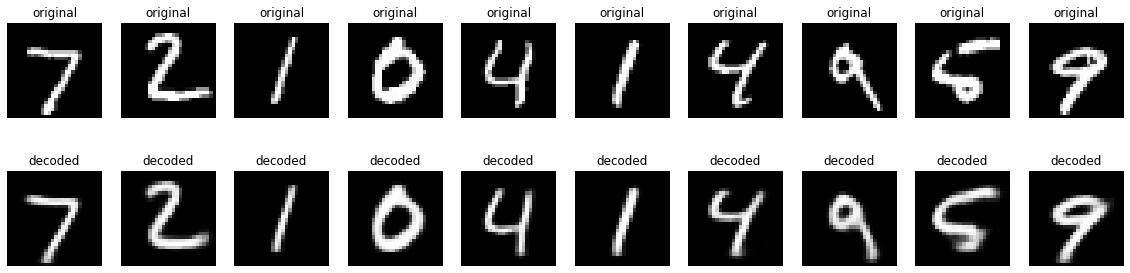

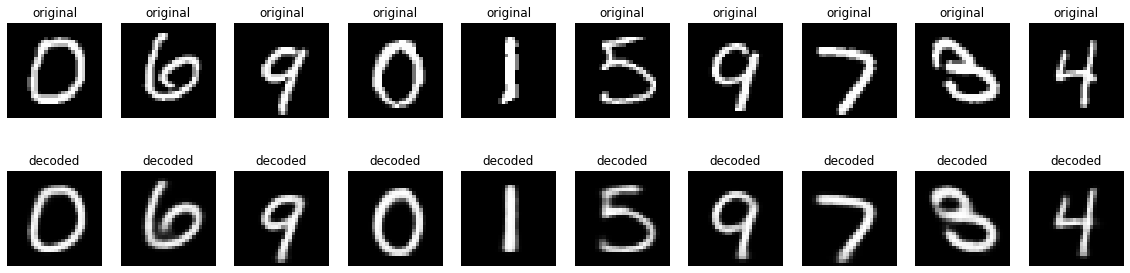

In [32]:
# первые 20 картинок и их реконструкций из val выборки
v_autoencoder.eval()
X_val = next(iter(test_loader_mnist))[0][:10]
X_enc = v_autoencoder(X_val.float().to(device))[0].detach().cpu()
image_show(X_val, X_enc, cmap='gray')
X_val = next(iter(test_loader_mnist))[0][10:20]
X_enc = v_autoencoder(X_val.float().to(device))[0].detach().cpu()
image_show(X_val, X_enc, cmap='gray')

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

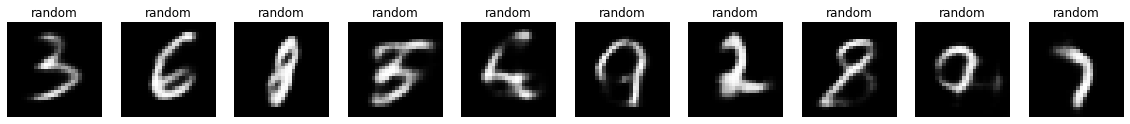

In [36]:
z = torch.normal(0, 1, size=(10, 128)).to(device)
v_autoencoder.eval()
output = v_autoencoder.decode(z)
output = output.detach().cpu()
image_show(output, t1='random', cmap='gray')

## Latent Representation

Давайте посмотрим, как латентные векторы картинок цифр выглядят в пространстве.

Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными цифрами.

In [37]:
latent_vectors = None
labels = None
v_autoencoder.eval()
for x_batch, y_batch in test_loader_mnist:
    x_batch = x_batch.to(device)
    # получим латентные ветора для батча
    latent_code, _ = v_autoencoder.encode(x_batch)
    
    if latent_vectors is not None:
        # сложим их в 1 тензор
        latent_vectors = torch.cat((latent_vectors, latent_code), dim=0)
        labels = torch.cat((labels, y_batch), dim=0)
    else:
        latent_vectors = latent_code.clone()
        labels = y_batch.clone()

In [38]:
latent_vectors = latent_vectors.detach().cpu().numpy()
labels = labels.detach().cpu().numpy()

In [39]:
%%time
# сожмем до размерности 2
X_embedded = TSNE(n_components=2).fit_transform(latent_vectors)

Wall time: 43.1 s


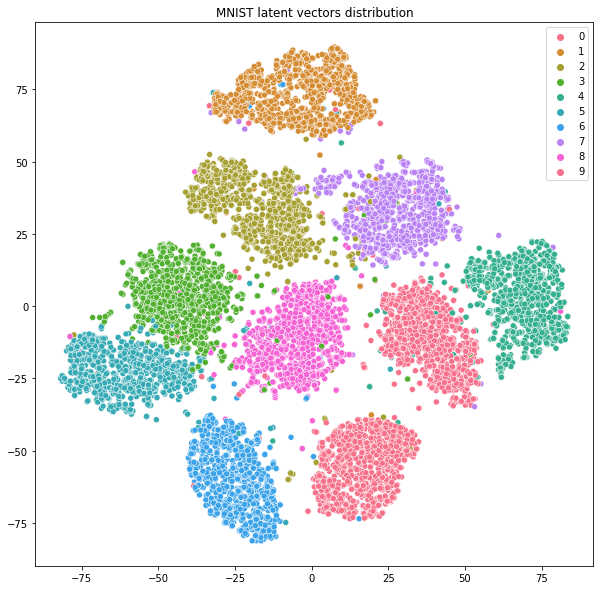

In [40]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=labels, palette="husl", legend='full').set(
    title='MNIST latent vectors distribution');

# Conditional VAE

Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!


## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



В качестве датасета возьмем MNIST. В качестве модели возьмем реализованный в прошлом шаге VAE. Будем конкатенировать выход из него после сверток с вектором из лейбла цифры, закодированного с помощью one hot encoder. 

In [41]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        
        self.fc_mu = nn.Linear(latent_dim+10, latent_dim)
        self.fc_logsigma = nn.Linear(latent_dim+10, latent_dim)
        self.hidden_out = nn.Linear(latent_dim+10, latent_dim)
        
        self.latent_dim = latent_dim
        
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.BatchNorm2d(64),            
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2),
            nn.Sigmoid()
        )
    def ohe(self, y):
        # преобразуем вектор с лейблами цифр в тензор, 
        # где вместо значения цифры будет вектор из 9 нулей и 1 единицы, стоящей по индексу == значению цифры
        y = y.view(-1, 1)
        y_ohe = torch.zeros(y.size(0), 10).to(device)
        y_ohe.scatter_(1, y.data, 1)
        return y_ohe 
    
    def encode(self, x, y):
        x = self.encoder(x)
        # распрямим выход из сверточного энкодера в вид [batch_size, -1]
        x = x.view(x.size(0), -1)
        # преобразуем вектор лейблов
        y = self.ohe(y)
        # конкатенируем его с выходом из сверточного энкодера
        x = torch.cat((x, y), dim=1)
        
        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(logsigma / 2)
            q = torch.distributions.Normal(mu, std)
            z = q.rsample()
            return z
        else:
            return mu
    
    def decode(self, x, y):
        # преобразуем вектор лейблов
        y = self.ohe(y)
        # конкатенируем его с выходом из скрытого слоя
        x = torch.cat((x, y), dim=1)
        # линейное преобразование перед сверточным декодером, 
        # чтобы размерность соответствовала количеству каналов
        x = self.hidden_out(x)
        x = x.view(x.size(0), self.latent_dim, 1, 1)
        reconstruction = self.decoder(x)

        return reconstruction

    def forward(self, x_y):
        # в форвард передается 1 переменная - кортеж из данных и лейблов, разделим его
        x = x_y[0]
        y = x_y[1]
        mu, logsigma = self.encode(x, y)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, y)
        
        return reconstruction, (mu, logsigma)

Обучим модель.

In [42]:
cv_autoencoder = CVAE().to(device)

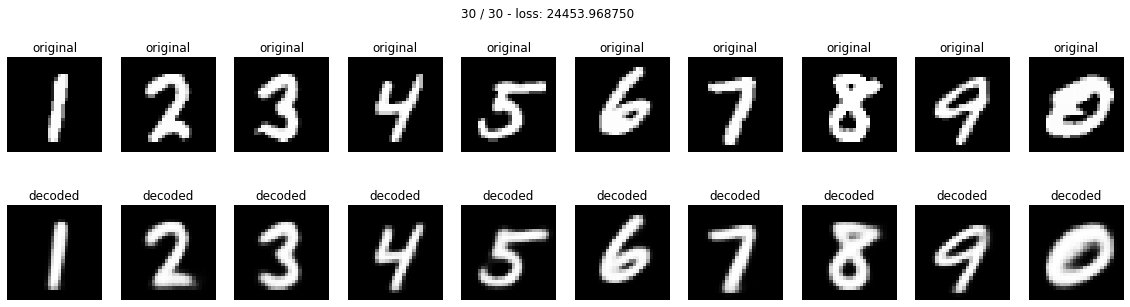

Wall time: 3min 2s


In [43]:
%%time
max_epochs = 30
criterion = loss_vae
optimizer = torch.optim.Adam(cv_autoencoder.parameters(), lr=0.001)
history = train(cv_autoencoder, optimizer, criterion, max_epochs, 
                train_loader_mnist, test_loader_mnist, pictures=True, 
                model_type='CVAE', data='mnist', cmap='gray')

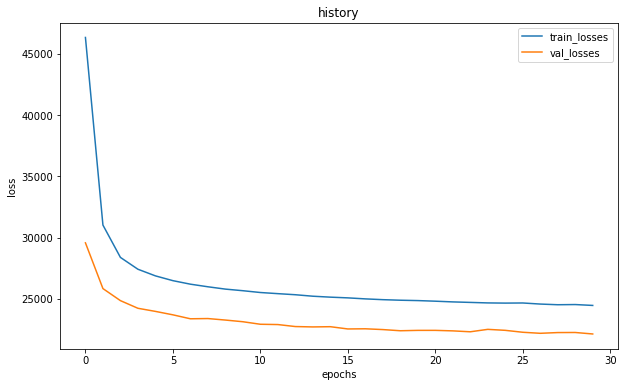

In [44]:
history_plot(history)

## Sampling


Создадим случайный вектор и сгенерируем из него все 10 цифр. (чем меньше std, тем ближе друг к другу цифры, чем больше, тем дальше, вплоть до перехода в другую цифру)

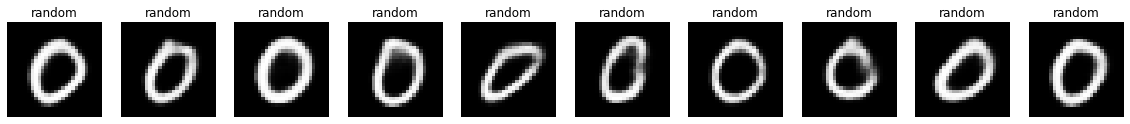

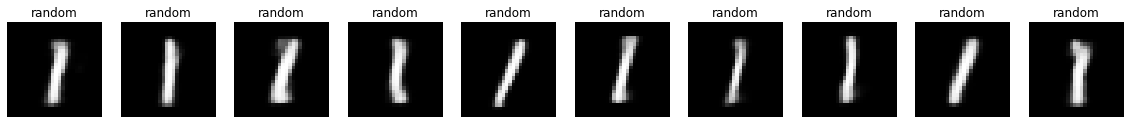

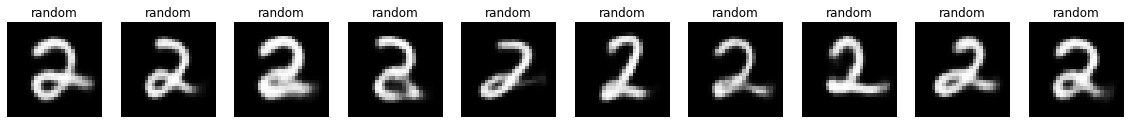

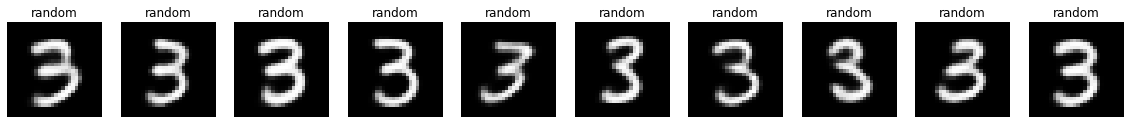

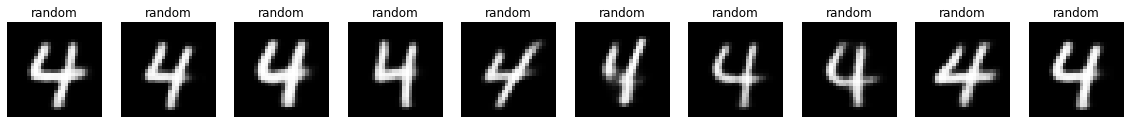

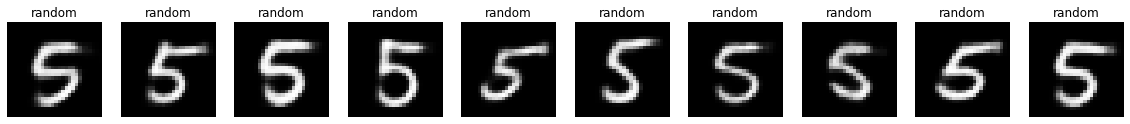

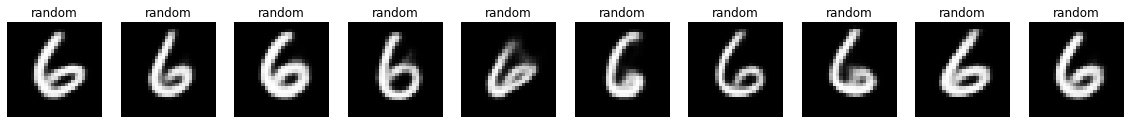

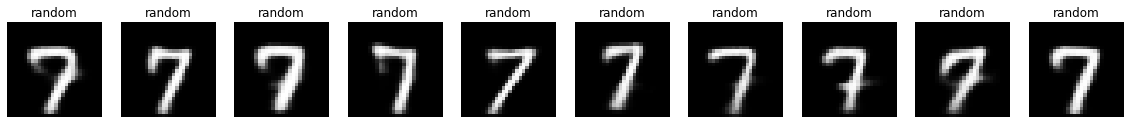

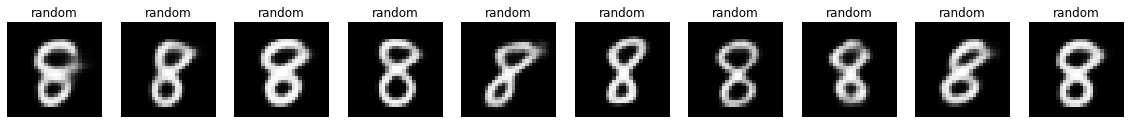

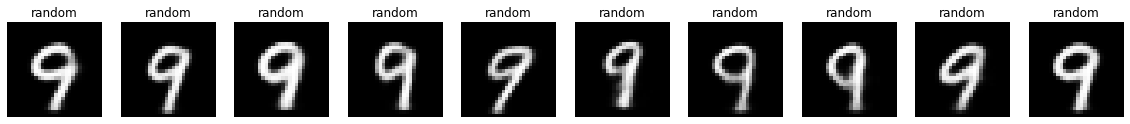

In [47]:
z = torch.normal(0, 0.5, size=(10, 128)).to(device)
cv_autoencoder.eval()
y = torch.zeros(10).to(device).to(torch.int64)
for _ in range(10):
    output = cv_autoencoder.decode(z, y)
    output = output.detach().cpu()
    image_show(output, t1='random', cmap='gray')
    y += 1

## Latent Representations

Посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

In [48]:
latent_vectors = None
labels = None
cv_autoencoder.eval()
for x_batch, y_batch in test_loader_mnist:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    latent_code, _ = cv_autoencoder.encode(x_batch, y_batch)
    
    if latent_vectors is not None:
        latent_vectors = torch.cat((latent_vectors, latent_code), dim=0)
        labels = torch.cat((labels, y_batch), dim=0)
    else:
        latent_vectors = latent_code.clone()
        labels = y_batch.clone()

In [49]:
latent_vectors = latent_vectors.detach().cpu().numpy()
labels = labels.detach().cpu().numpy()

In [50]:
%%time
X_embedded = TSNE(n_components=2).fit_transform(latent_vectors)

Wall time: 43.9 s


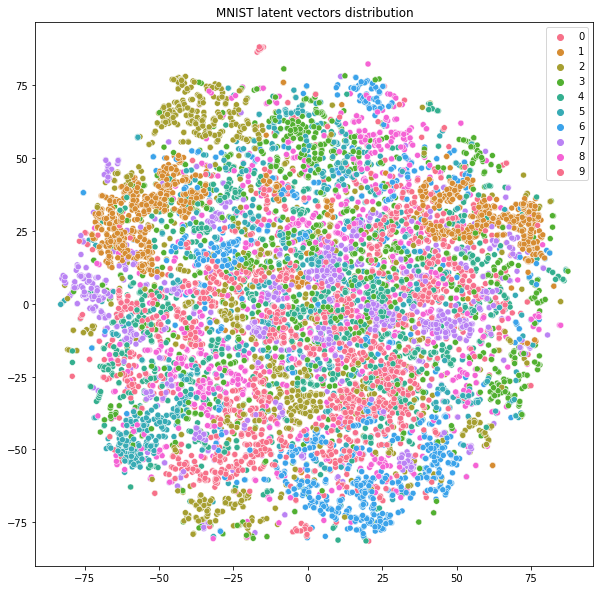

In [51]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=labels, palette="husl", legend='full').set(
    title='MNIST latent vectors distribution');

Image Morphing

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [52]:
def morphing(im1, im2):
    """Ф-я, принимающая 2 изображения и строящая 20 промежуточных между ними"""
    morphing = None
    # возьмем 20 значений alpha
    for alpha in np.linspace(0, 1, 20):
        # посчитаем с каждой из них новый код
        im_new_code = (1-alpha) * im1_code + alpha * im2_code
        # прогоним его через декодер
        im_new = autoencoder.decode(im_new_code.to(device)).detach().cpu()
        # сложим это все в тензор
        if morphing is not None:
            morphing = torch.cat((morphing, im_new), dim=0)
        else:
            morphing = im_new.clone()
    return morphing

Возьмем 2 изображения

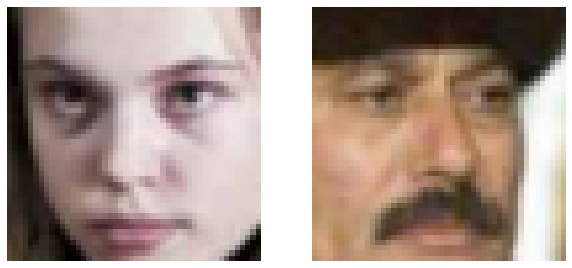

In [53]:
im1 = data[111]
im2 = data[333]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(im1)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(im2);

In [54]:
im1_code = autoencoder.encode(torch.FloatTensor(np.moveaxis(im1, 2, 0)).to(device).unsqueeze(0))
im2_code = autoencoder.encode(torch.FloatTensor(np.moveaxis(im2, 2, 0)).to(device).unsqueeze(0))

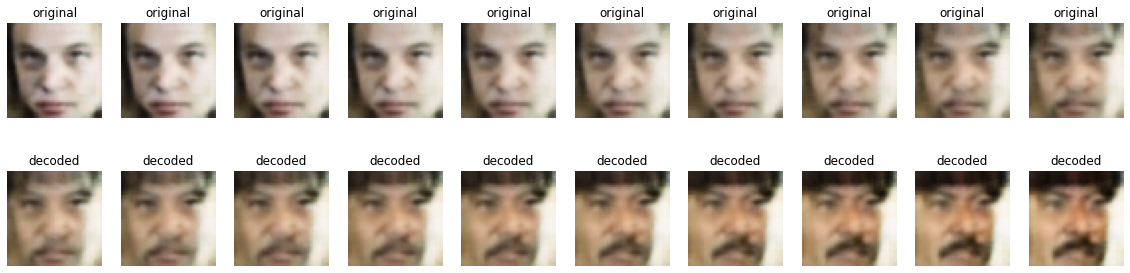

In [55]:
image_show(morphing(im1_code, im2_code)[:10], morphing(im1_code, im2_code)[10:])

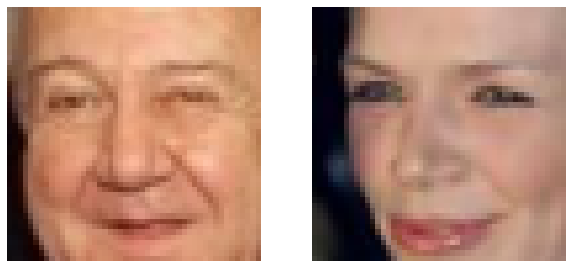

In [56]:
im1 = data[-2]
im2 = data[-10]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(im1)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(im2);

In [57]:
im1_code = autoencoder.encode(torch.FloatTensor(np.moveaxis(im1, 2, 0)).to(device).unsqueeze(0))
im2_code = autoencoder.encode(torch.FloatTensor(np.moveaxis(im2, 2, 0)).to(device).unsqueeze(0))

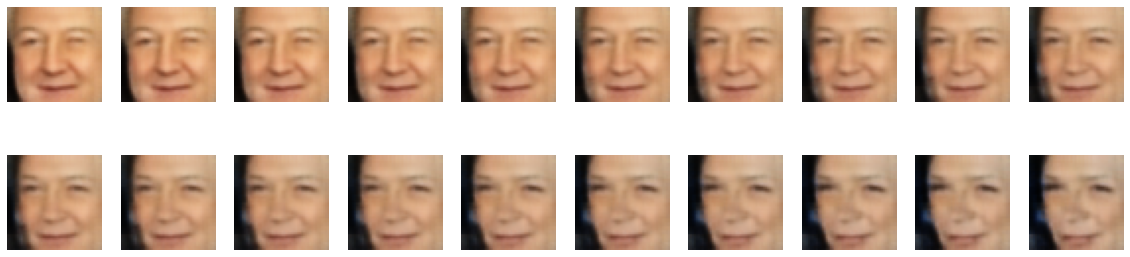

In [58]:
image_show(morphing(im1_code, im2_code)[:10], morphing(im1_code, im2_code)[10:], t1=None, t2=None)

Denoising

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

In [59]:
noise_factor = 0.5

In [60]:
noisy_autoencoder = Autoencoder().to(device)

Обучение на зашумленных данных я реализовал в ф-ии train. Для этого надо лишь подать в неё параметр noise_factor отличный от нуля. Шум добавляется к каждому обучающему и валидационному батчу перед подачей в модель.

Обучим модель.

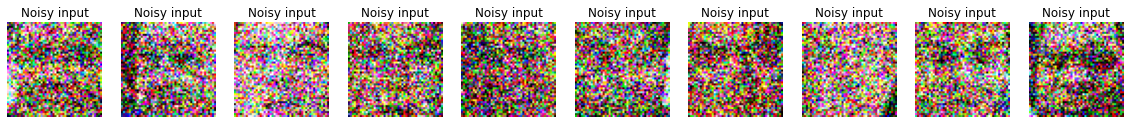

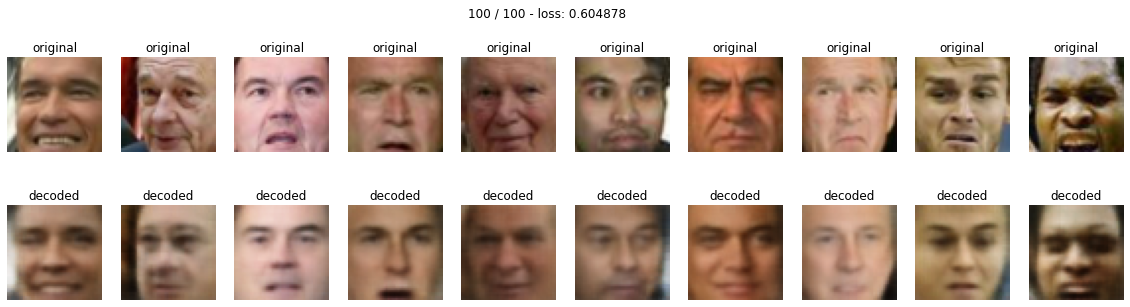

Wall time: 4min 22s


In [61]:
%%time
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(noisy_autoencoder.parameters(), lr=0.01)
max_epochs = 100
history = train(noisy_autoencoder, optimizer, criterion, max_epochs, 
                train_loader, val_loader, pictures=True, noise_factor=noise_factor)

Возьмем еще 10 изображений из валидационной выборки, добавим к ним шум и прогоним через модель.

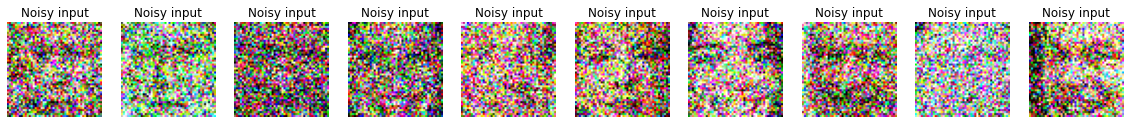

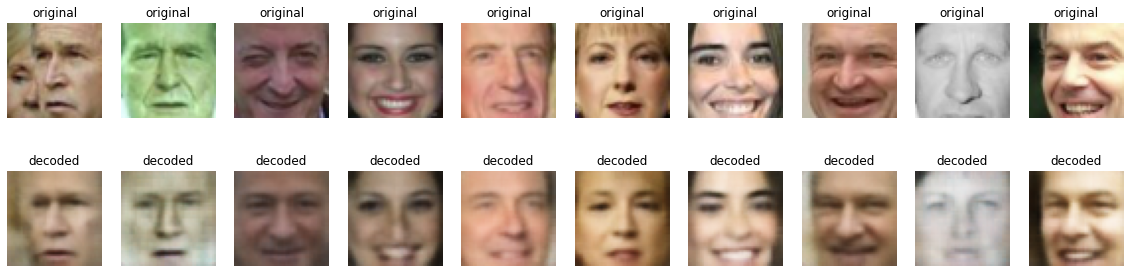

In [62]:
X_val = next(iter(val_loader))[200:]
X_noisy = noise_factor * torch.randn((X_val.size()))
X_input = X_val + X_noisy
input_img = np.clip(X_input, 0, 1)
image_show(input_img, num=10, t1='Noisy input')

noisy_autoencoder.eval()
X_enc = noisy_autoencoder(X_input.float().to(device))[0].detach().cpu()
image_show(X_val, X_enc)

Image Retrieval

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем NearestNeighbors
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного NearestNeighbors ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Мы получали латентные представления всех лиц трейна в пункте, где генерировали лица из шума, они хранятся в переменной latent_codes

In [63]:
X = latent_codes.reshape((latent_codes.shape[0], -1))
X.shape

(10514, 256)

In [64]:
from sklearn.neighbors import NearestNeighbors

# обучим NearestNeighbors на латентных векторах train выборки.
nbrs = NearestNeighbors(n_neighbors=11, algorithm='ball_tree').fit(X)

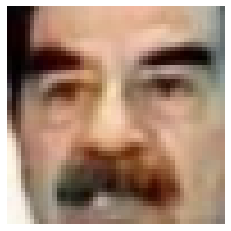

In [81]:
# выберем случайную фотку из тестовой базы:
idx = np.random.randint(data_val.shape[0], size=1)[0]
test_img = data_val[idx]
plt.axis('off')
plt.imshow(test_img);

In [82]:
def get_similar(image, n_neighbors=11):
    """функция, которая берет тестовый image и ищет ближайшие векторы"""
    
    # прогоним изображение через энкодер
    code = autoencoder.encode(torch.FloatTensor(np.moveaxis(image, 2, 0)).to(device).unsqueeze(0))
    code = code.detach().cpu().numpy().reshape((code.shape[0], -1))
    # вычислим расстояния и индексы ближайших векторов
    distances, indices = nbrs.kneighbors(code)
    indices = indices.flatten()
    distances = distances.flatten()
    return distances, data_train[indices]


def show_similar(image):
    """функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат"""
    
    distances, neighbors = get_similar(image)
    
    plt.figure(figsize=[18, 12])
    plt.subplot(3, 4, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3, 4, i+2)
        plt.imshow(neighbors[i])
        plt.axis('off')
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [83]:
# самые похожие лица из тестовой части датасета>

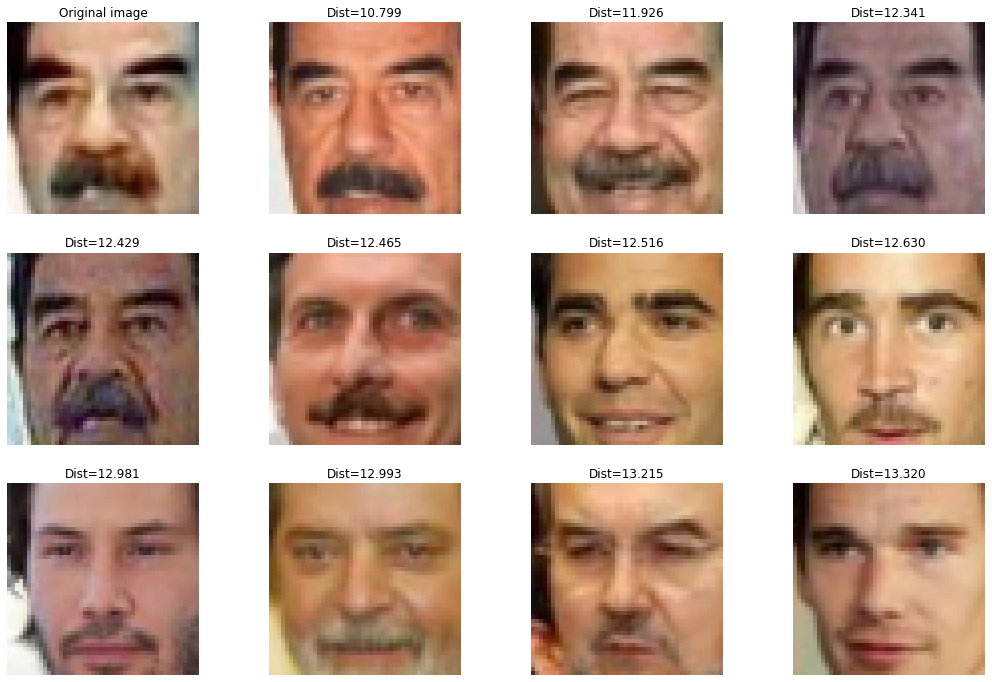

In [84]:
show_similar(test_img)